In [3]:
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so
import numpy as np
from load_jsondata import read_data

In [4]:
import py_newton_optimizer
def deployment(input_path, target_mesh_path, deployment_ratio):
    input_data, io = read_data(filepath = input_path)
    width = 6 #2*input_data['arm_plate_edge_offset']
    thickness = width * 0.5 # 1.5 mm # FIX from mm to meters everywhere
    cross_section = [thickness, width]
    curr_um = umbrella_mesh.UmbrellaMesh(target_mesh_path, io)
    curr_um.setMaterial(elastic_rods.RodMaterial('rectangle', 1400, 0.35, cross_section, stiffAxis=elastic_rods.StiffAxis.D1), 
                    elastic_rods.RodMaterial('rectangle', 14000, 0.35, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    curr_um.energy(UmbrellaEnergyType.Full)

    driver = curr_um.centralJoint()
    jdo = curr_um.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) + curr_um.rigidJointAngleDoFIndices()

    
    OPTS = py_newton_optimizer.NewtonOptimizerOptions()
    OPTS.gradTol = 1e-5
    OPTS.verbose = 1
    OPTS.beta = 1e-6
    OPTS.niter = 2000
    OPTS.verboseNonPosDef = False

    dof = curr_um.getDoFs()
    for i in range(curr_um.numJoints()):
        if (curr_um.joint(i).jointType() == umbrella_mesh.JointType.X):
            dof[curr_um.dofOffsetForJoint(i) + 6] = 1e-3
    curr_um.setDoFs(dof)

    curr_um.uniformDeploymentEnergyWeight = 0.1
    curr_um.targetDeploymentHeight = deployment_ratio*thickness
    curr_um.attractionWeight = 0
    curr_um.setHoldClosestPointsFixed(False)
    curr_um.scaleInputPosWeights(0.5)


    report1 = umbrella_mesh.compute_equilibrium(curr_um, options = OPTS, fixedVars = fixedVars)
    curr_um.uniformDeploymentEnergyWeight = 0.1
    report1 = umbrella_mesh.compute_equilibrium(curr_um, options = OPTS, fixedVars = fixedVars)
    h1 = curr_um.umbrellaHeights
    e1 = curr_um.energyElastic()

    curr_um.uniformDeploymentEnergyWeight = 0
    curr_um.attractionWeight = 0
    
    report2 = umbrella_mesh.compute_equilibrium(curr_um, options = OPTS, fixedVars = fixedVars)
    h2 = curr_um.umbrellaHeights
    e2 = curr_um.energyElastic()

    return report1, report2, h1/thickness, h2/thickness, e1, e2
    
    

In [4]:
energies1 = []
energies2 = []
thickness_factors = [1,2,4,6,8,10]
for thickness_factor in thickness_factors:
    # with so():
    r1, r2, h1, h2, e1, e2 = deployment('../../data/paraboloid.json','../../data/target_meshes/paraboloid.obj', thickness_factor)
    energies1.append(e1)
    energies2.append(e2)

0	86384.9	881.168	881.168	0.000183836	0
1	86384.4	1188.9	1188.9	0.0046415	1
Added constraint 1442 to working set
Added constraint 1445 to working set
Added constraint 1479 to working set
Added constraint 1481 to working set
Added constraint 1489 to working set
Added constraint 1647 to working set
Added constraint 1652 to working set
Added constraint 1716 to working set
Added constraint 1776 to working set
Added constraint 1809 to working set
2	86379.5	1174.77	1174.68	0.00103555	1
Added constraint 1432 to working set
Added constraint 1435 to working set
Added constraint 1437 to working set
Added constraint 1440 to working set
Added constraint 1484 to working set
Added constraint 1486 to working set
Added constraint 1544 to working set
Added constraint 1566 to working set
Added constraint 1732 to working set
Added constraint 1807 to working set
Added constraint 1841 to working set
Added constraint 1844 to working set
3	86378.4	1163.84	1163.45	0.00105558	1
Added constraint 1451 to working

[1515.641827443737, 1524.3601458552698, 1516.3330593171027, 1517.7348928414372, 1570.6659434836286, 1663.834632448861]
[1487.8814628476348, 1508.630636169442, 1508.6306361693707, 1486.2863922782046, 1486.2863922782828, 1486.2863922783133]


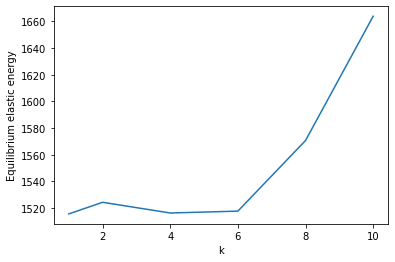

In [7]:
import importlib
import matplotlib
importlib.reload(matplotlib.pyplot)
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(thickness_factors, energies1)
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('Equilibrium elastic energy')
print(energies1)
print(energies2)

#### Distance Deployment

In [9]:

import mesh
from visualization_helper import *
target_mesh_path = '../../data/target_meshes/paraboloid.obj'
target_mesh = mesh.Mesh(target_mesh_path)
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)

view.show()

NameError: name 'curr_um' is not defined

4367.130085850729 4236.016594260602


(array([2., 2., 0., 2., 4., 1., 3., 4., 1., 3.]),
 array([0.49094192, 0.55275697, 0.61457202, 0.67638707, 0.73820212,
        0.80001717, 0.86183221, 0.92364726, 0.98546231, 1.04727736,
        1.10909241]),
 <a list of 10 Patch objects>)

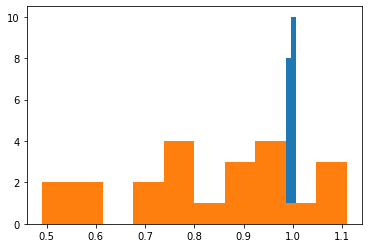

In [8]:
print(r1.energy[-1], r2.energy[-1])

plt.hist(h1)
plt.hist(h2)

In [10]:
rod_colors = []
for ri in range(curr_um.numSegments()):
    rod_colors.append(np.ones(curr_um.segment(ri).rod.numVertices()) * ri)

In [11]:
view = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
view.averagedMaterialFrames = True
view.update(scalarField = rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

4.5


(array([3., 6., 0., 0., 3., 6., 0., 0., 3., 1.]),
 array([ 60.        ,  65.83180519,  71.66361039,  77.49541558,
         83.32722078,  89.15902597,  94.99083116, 100.82263636,
        106.65444155, 112.48624675, 118.31805194]),
 <a list of 10 Patch objects>)

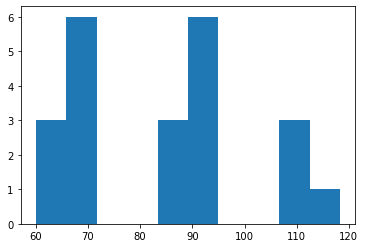

In [6]:
print(thickness)
curr_um.umbrellaHeights
import matplotlib.pyplot as plt
plt.hist(curr_um.umbrellaHeights)

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
for i in range(len(angles[0])):
    plt.plot([a[i] / np.pi for a in angles])
plt.title('Joint Angles')
plt.xlabel('Newton Iteration')
plt.ylabel('Pi Radians')
plt.tight_layout()
plt.show()

In [ ]:
np.linalg.norm(curr_um.gradient())

In [ ]:
len([j.jointType() for j in curr_um.joints()])

In [ ]:
len(curr_um.jointAngleDoFIndices())

In [ ]:
curr_um.getDoFs()[curr_um.jointAngleDoFIndices()]

In [ ]:
import umbrella_finite_diff
umbrella_finite_diff.gradient_convergence_plot(curr_um, umbrellaEnergyType=umbrella_mesh.UmbrellaEnergyType.Deployment, etype=elastic_rods.EnergyType.Full)

In [ ]:
curr_um.updateSourceFrame()

In [ ]:
umbrella_finite_diff.hessian_convergence_plot(curr_um, umbrellaEnergyType=umbrella_mesh.UmbrellaEnergyType.Deployment, etype=elastic_rods.EnergyType.Full)

In [ ]:
bending_stress = curr_um.maxBendingStresses()

In [ ]:
view.update(scalarField=bending_stress)